In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords
from collections import Counter
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


Train size: 86945
Validation size: 18631
Test size: 18632


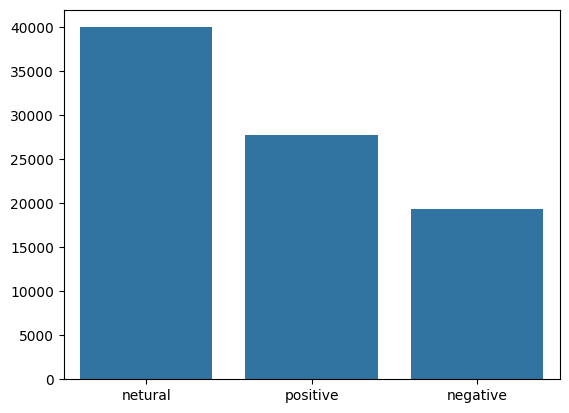

1    39944
2    27678
0    19323
Name: count, dtype: int64


In [2]:

# Load data
data = pd.read_csv('../dataset/process/tweets_cleaned_emoticons_emojis_convert_cleaned.tsv', sep='\t')
data = data.dropna()

X = data['reduced_clean_text'].values
y = data['sentiment'].values

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Train size: {len(X_train)}')
print(f'Validation size: {len(X_val)}')
print(f'Test size: {len(X_test)}')

# Plot class distribution
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['netural', 'positive', 'negative']), y=dd.values)
plt.show()

print(dd)

In [3]:
# total positive, negative and neutral tweets
positive_tweets = data[data['sentiment'] == 2]
negative_tweets = data[data['sentiment'] == 0]
neutral_tweets = data[data['sentiment'] == 1]

print(f'Total positive tweets: {len(positive_tweets)}')
print(f'Total negative tweets: {len(negative_tweets)}')
print(f'Total neutral tweets: {len(neutral_tweets)}')

Total positive tweets: 39633
Total negative tweets: 27617
Total neutral tweets: 56958


In [4]:
# Preprocess function
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\s+", ' ', s)
    s = re.sub(r"\d", '', s)
    return s

# Tokenize function
def tokenize(x_train, x_val, x_test):
    word_list = []
    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # Create a vocabulary index
    vocab = {word: idx for idx, (word, _) in enumerate(corpus.items(), 1)}

    def encode(sentences):
        return [[vocab[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in vocab] for sent in sentences]

    x_train_encoded = encode(x_train)
    x_val_encoded = encode(x_val)
    x_test_encoded = encode(x_test)
    
    # Pad sequences
    x_train_padded = pad_sequence([torch.tensor(x) for x in x_train_encoded], batch_first=True, padding_value=0)
    x_val_padded = pad_sequence([torch.tensor(x) for x in x_val_encoded], batch_first=True, padding_value=0)
    x_test_padded = pad_sequence([torch.tensor(x) for x in x_test_encoded], batch_first=True, padding_value=0)
    
    return x_train_padded, x_val_padded, x_test_padded, vocab

X_train_padded, X_val_padded, X_test_padded, vocab = tokenize(X_train, X_val, X_test)
y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)
y_test_tensor = torch.tensor(y_test)

# Load pre-trained GloVe embeddings
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            embedding = np.array(values[1:], dtype='float32')
            embeddings_index[word] = embedding
    return embeddings_index

glove_embeddings = load_glove_embeddings('../dataset/glove_twitter_27B/glove.twitter.27B.100d.txt')

# Check for missing words in GloVe
missing_words = [word for word in vocab.keys() if word not in glove_embeddings]
print(f'Missing words in GloVe: {len(missing_words)}/{len(vocab)}')

# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))
for word, i in vocab.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Missing words in GloVe: 20665/47373


In [5]:
class SentimentBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, embedding_matrix):
        super(SentimentBiLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 because of bidirectional
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        lstm_out, _ = self.lstm(embedded)
        final_feature_map = self.dropout(torch.cat((lstm_out[:, -1, :hidden_dim], lstm_out[:, 0, hidden_dim:]), dim=1))
        final_out = self.fc(final_feature_map)
        return final_out

100%|██████████| 292/292 [00:21<00:00, 13.71it/s]


Epoch 1/10, Training Loss: 0.8936386076381225, Validation Loss: 0.831545473165708, Training Accuracy: 0.5742594264945259, Validation Accuracy: 0.6218581824853229


100%|██████████| 292/292 [00:21<00:00, 13.73it/s]


Epoch 2/10, Training Loss: 0.8504537265032333, Validation Loss: 0.815217236133471, Training Accuracy: 0.6071319569870894, Validation Accuracy: 0.6271021893346379


100%|██████████| 292/292 [00:21<00:00, 13.33it/s]


Epoch 3/10, Training Loss: 0.835065732596989, Validation Loss: 0.7956294172430691, Training Accuracy: 0.6194220070461792, Validation Accuracy: 0.6440725905088063


100%|██████████| 292/292 [00:20<00:00, 14.06it/s]


Epoch 4/10, Training Loss: 0.8233380907155556, Validation Loss: 0.7885159743975286, Training Accuracy: 0.6246592581443574, Validation Accuracy: 0.6462588674168297


100%|██████████| 292/292 [00:20<00:00, 14.36it/s]


Epoch 5/10, Training Loss: 0.8140990952957721, Validation Loss: 0.7949474092623959, Training Accuracy: 0.6301957906883403, Validation Accuracy: 0.6388744496086105


100%|██████████| 292/292 [00:18<00:00, 15.49it/s]


Epoch 6/10, Training Loss: 0.802795386428426, Validation Loss: 0.7906825150528999, Training Accuracy: 0.6364239107409637, Validation Accuracy: 0.6488273605675147


100%|██████████| 292/292 [00:19<00:00, 14.79it/s]


Epoch 7/10, Training Loss: 0.794750728179112, Validation Loss: 0.7781535725887507, Training Accuracy: 0.6399076303877629, Validation Accuracy: 0.6538573263209393


100%|██████████| 292/292 [00:19<00:00, 14.78it/s]


Epoch 8/10, Training Loss: 0.7863721605431429, Validation Loss: 0.7779733624360333, Training Accuracy: 0.6443233382389011, Validation Accuracy: 0.6486744740704502


100%|██████████| 292/292 [00:20<00:00, 14.59it/s]


Epoch 9/10, Training Loss: 0.7807741876557261, Validation Loss: 0.7804381198262516, Training Accuracy: 0.6480018172898968, Validation Accuracy: 0.6522673067514676


100%|██████████| 292/292 [00:19<00:00, 15.34it/s]


Epoch 10/10, Training Loss: 0.7735406867364824, Validation Loss: 0.7764703398697996, Training Accuracy: 0.650442755368252, Validation Accuracy: 0.6561124021526419


100%|██████████| 292/292 [00:17<00:00, 16.43it/s]


Test Accuracy: 0.6566245719178082


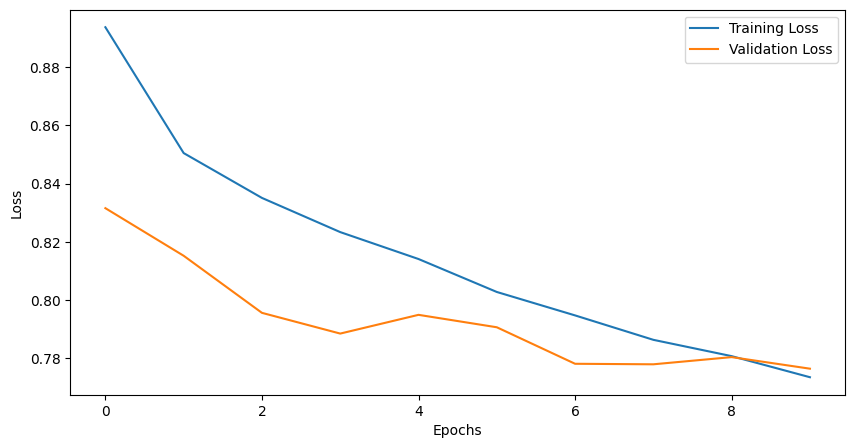

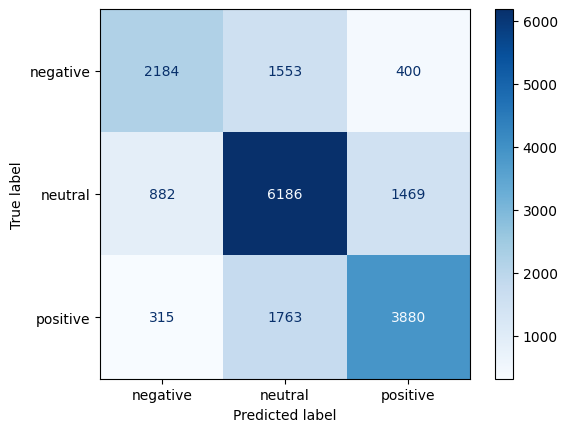

In [6]:
# Hyperparameters
vocab_size = len(vocab) + 1
hidden_dim = 256
output_dim = 3
n_layers = 2
dropout = 0.5

model = SentimentBiLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, embedding_matrix)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Accuracy calculation function
def calculate_accuracy(preds, y):
    _, pred_classes = torch.max(preds, 1)
    correct = (pred_classes == y).sum().item()
    return correct / len(y)

# Training loop
epochs = 10
patience = 3
best_val_loss = float('inf')
early_stopping_counter = 0

train_losses_over_time = []
val_losses_over_time = []

for epoch in range(epochs):
    model.train()
    train_losses = []
    train_accuracies = []
    for inputs, labels in tqdm(DataLoader(TensorDataset(X_train_padded, y_train_tensor), batch_size=64, shuffle=True)):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        train_accuracies.append(calculate_accuracy(outputs, labels))

    model.eval()
    val_losses = []
    val_accuracies = []
    with torch.no_grad():
        for inputs, labels in tqdm(DataLoader(TensorDataset(X_val_padded, y_val_tensor), batch_size=64, shuffle=False)):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            val_accuracies.append(calculate_accuracy(outputs, labels))

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    train_accuracy = np.mean(train_accuracies)
    val_accuracy = np.mean(val_accuracies)
    
    train_losses_over_time.append(train_loss)
    val_losses_over_time.append(val_loss)
    
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_bilstm_convert_model.pt')


model.load_state_dict(torch.load('best_bilstm_convert_model.pt'))
model.eval()
test_accuracies = []
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in tqdm(DataLoader(TensorDataset(X_test_padded, y_test_tensor), batch_size=64, shuffle=False)):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_accuracies.append(calculate_accuracy(outputs, labels))
        all_preds.append(outputs.cpu())
        all_labels.append(labels.cpu())

test_accuracy = np.mean(test_accuracies)
print(f'Test Accuracy: {test_accuracy}')

# Plot loss over time
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses_over_time)), train_losses_over_time, label='Training Loss')
plt.plot(range(len(val_losses_over_time)), val_losses_over_time, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot confusion matrix
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
_, pred_classes = torch.max(all_preds, 1)
cm = confusion_matrix(all_labels, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [7]:
import torch
print("CUDA is available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("PyTorch version:", torch.__version__)


CUDA is available: True
CUDA version: 12.1
PyTorch version: 2.3.1+cu121
